<a href="https://colab.research.google.com/github/MehulSuthar-000/text_classification/blob/main/Text_Classification_using_multiple_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [130]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import _stop_words

import string
import re


from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.metrics import accuracy_score

from sklearn.metrics import confusion_matrix
from sklearn import metrics


from time import time

import nltk

from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer

In [131]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [132]:
# getting the data set from github repository
try:
    from google.colab import files
    !wget -P DATAPATH https://raw.githubusercontent.com/practical-nlp/practical-nlp/master/Ch4/Data/Full-Economic-News-DFE-839861.csv
    !ls -lah DATAPATH
    our_data = pd.read_csv("DATAPATH/Full-Economic-News-DFE-839861.csv" , encoding = "ISO-8859-1" )

except ModuleNotFoundError:
    our_data = pd.read_csv("Data/Full-Economic-News-DFE-839861.csv" , encoding = "ISO-8859-1" )

--2024-05-16 11:21:47--  https://raw.githubusercontent.com/practical-nlp/practical-nlp/master/Ch4/Data/Full-Economic-News-DFE-839861.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12383529 (12M) [text/plain]
Saving to: ‘DATAPATH/Full-Economic-News-DFE-839861.csv.4’

Full-Economic-News- 100%[===================>]  11.81M  --.-KB/s    in 0.1s    

2024-05-16 11:21:48 (110 MB/s) - ‘DATAPATH/Full-Economic-News-DFE-839861.csv.4’ saved [12383529/12383529]

total 60M
drwxr-xr-x 2 root root 4.0K May 16 11:21 .
drwxr-xr-x 1 root root 4.0K May 16 10:53 ..
-rw-r--r-- 1 root root  12M May 16 10:53 Full-Economic-News-DFE-839861.csv
-rw-r--r-- 1 root root  12M May 16 10:58 Full-Economic-News-DFE-839861.csv.1
-rw-r--r-- 1 root root  12M May 16 10:59 Full-Economic-News

In [133]:
our_data.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,positivity,positivity:confidence,relevance,relevance:confidence,articleid,date,headline,positivity_gold,relevance_gold,text
0,842613455,False,finalized,3,12/5/15 17:48,3.0,0.6400,yes,0.640,wsj_398217788,8/14/91,Yields on CDs Fell in the Latest Week,NaN,NaN,NEW YORK -- Yields on most certificates of dep...
1,842613456,False,finalized,3,12/5/15 16:54,NaN,NaN,no,1.000,wsj_399019502,8/21/07,The Morning Brief: White House Seeks to Limit ...,NaN,NaN,The Wall Street Journal Online</br></br>The Mo...
2,842613457,False,finalized,3,12/5/15 1:59,NaN,NaN,no,1.000,wsj_398284048,11/14/91,Banking Bill Negotiators Set Compromise --- Pl...,NaN,NaN,WASHINGTON -- In an effort to achieve banking ...
3,842613458,False,finalized,3,12/5/15 2:19,NaN,0.0000,no,0.675,wsj_397959018,6/16/86,Manager's Journal: Sniffing Out Drug Abusers I...,NaN,NaN,The statistics on the enormous costs of employ...
4,842613459,False,finalized,3,12/5/15 17:48,3.0,0.3257,yes,0.640,wsj_398838054,10/4/02,Currency Trading: Dollar Remains in Tight Rang...,NaN,NaN,NEW YORK -- Indecision marked the dollar's ton...


In [134]:
# relevance is the target/independent variable we need to predict/classify
our_data['relevance'].value_counts()/our_data.shape[0]

relevance
no          0.821375
yes         0.177500
not sure    0.001125
Name: count, dtype: float64

The data set is about whether article is relevant to US Economy or not. Since most of the article are not related US Economy which makes scene in a real-world scenario as news article discuss various topics.

In [135]:
# not sure is a useless class for us as per this experiments scope
our_data = our_data[our_data.relevance != "not sure"] # saving all data except not sure class
our_data.shape

(7991, 15)

In [136]:
# yes = 1 and no = 0
# let's encode the values in this column
our_data['relevance'] = our_data.relevance.map({'yes' : 1 , "no" : 0})

# we are taking in consideration only two columns that is the article and the label column for this task
our_data = our_data[["text" , 'relevance']]
our_data.shape

<ipython-input-136-ed336c3836da>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  our_data['relevance'] = our_data.relevance.map({'yes' : 1 , "no" : 0})


(7991, 2)

In [137]:
# let's inspect single article how it looks
our_data['text'][0]

'NEW YORK -- Yields on most certificates of deposit offered by major banks dropped more than a tenth of a percentage point in the latest week, reflecting the overall decline in short-term interest rates.</br></br>On small-denomination, or "consumer," CDs sold directly by banks, the average yield on six-month deposits fell to 5.49% from 5.62% in the week ended yesterday, according to an 18-bank survey by Banxquote Money Markets, a Wilmington, Del., information service.</br></br>On three-month "consumer" deposits, the average yield sank to 5.29% from 5.42% the week before, according to Banxquote. Two banks in the Banxquote survey, Citibank in New York and CoreStates in Pennsylvania, are paying less than 5% on threemonth small-denomination CDs.</br></br>Declines were somewhat smaller on five-year consumer CDs, which eased to 7.37% from 7.45%, Banxquote said.</br></br>Yields on three-month and six-month Treasury bills sold at Monday\'s auction plummeted more than a fifth of a percentage po

In [138]:
# after inspecting we see several issue with the text mostly because it is web scraped dataset.
# all text processing we will do\
# 1. lowercasing
# 2. removing punctuation
# 3. stopword removal (the task is to predict whether the article is relevant to US Economy).
#    we mostly need the word tokens related to US and finance stuff. no need of stopwords.
# 4. it mostly an intuition by i think here stemming will work
# 5. also we need to remove the html tags from the articles.

In [139]:
our_data['text'] = our_data['text'].str.lower()

In [140]:
def remove_html_tags(text):
  pattern = re.compile(r'<[^>]*>')
  return pattern.sub(r'' , text)

In [141]:
remove_html_tags(our_data['text'][0])

'new york -- yields on most certificates of deposit offered by major banks dropped more than a tenth of a percentage point in the latest week, reflecting the overall decline in short-term interest rates.on small-denomination, or "consumer," cds sold directly by banks, the average yield on six-month deposits fell to 5.49% from 5.62% in the week ended yesterday, according to an 18-bank survey by banxquote money markets, a wilmington, del., information service.on three-month "consumer" deposits, the average yield sank to 5.29% from 5.42% the week before, according to banxquote. two banks in the banxquote survey, citibank in new york and corestates in pennsylvania, are paying less than 5% on threemonth small-denomination cds.declines were somewhat smaller on five-year consumer cds, which eased to 7.37% from 7.45%, banxquote said.yields on three-month and six-month treasury bills sold at monday\'s auction plummeted more than a fifth of a percentage point from the previous week, to 5.46% and

In [142]:
import string
exclude = string.punctuation
def remove_punctuation(text):
    for char in exclude:
        text = text.replace(char, '')
    return text

In [143]:
our_data["text"] = our_data['text'].apply(remove_punctuation)

In [144]:
our_data['text'][0]

'new york  yields on most certificates of deposit offered by major banks dropped more than a tenth of a percentage point in the latest week reflecting the overall decline in shortterm interest ratesbrbron smalldenomination or consumer cds sold directly by banks the average yield on sixmonth deposits fell to 549 from 562 in the week ended yesterday according to an 18bank survey by banxquote money markets a wilmington del information servicebrbron threemonth consumer deposits the average yield sank to 529 from 542 the week before according to banxquote two banks in the banxquote survey citibank in new york and corestates in pennsylvania are paying less than 5 on threemonth smalldenomination cdsbrbrdeclines were somewhat smaller on fiveyear consumer cds which eased to 737 from 745 banxquote saidbrbryields on threemonth and sixmonth treasury bills sold at mondays auction plummeted more than a fifth of a percentage point from the previous week to 546 and 563 respectively'

In [145]:
our_data['text'] = our_data['text'].apply(remove_html_tags)

In [146]:
our_data['text'][0]

'new york  yields on most certificates of deposit offered by major banks dropped more than a tenth of a percentage point in the latest week reflecting the overall decline in shortterm interest ratesbrbron smalldenomination or consumer cds sold directly by banks the average yield on sixmonth deposits fell to 549 from 562 in the week ended yesterday according to an 18bank survey by banxquote money markets a wilmington del information servicebrbron threemonth consumer deposits the average yield sank to 529 from 542 the week before according to banxquote two banks in the banxquote survey citibank in new york and corestates in pennsylvania are paying less than 5 on threemonth smalldenomination cdsbrbrdeclines were somewhat smaller on fiveyear consumer cds which eased to 737 from 745 banxquote saidbrbryields on threemonth and sixmonth treasury bills sold at mondays auction plummeted more than a fifth of a percentage point from the previous week to 546 and 563 respectively'

In [147]:
our_data['text'] = our_data['text'].str.replace('\d+', '',regex=True)

In [148]:
stopwords = _stop_words.ENGLISH_STOP_WORDS
def remove_stopwords(text):
  doc = " ".join([token for token in text.split() if token not in stopwords])
  return doc

In [149]:
our_data['text'] = our_data['text'].apply(remove_stopwords)

In [150]:
# stemming the data
ps = PorterStemmer()
def stemmer(text):
  stemmed_tokens = []
  for word in text.split():
    stemmed_tokens.append(ps.stem(word))
  return " ".join(stemmed_tokens)

In [151]:
our_data['text'] = our_data['text'].apply(stemmer)

In [152]:
our_data['text'][0]

'new york yield certif deposit offer major bank drop tenth percentag point latest week reflect overal declin shortterm ratesbrbron smalldenomin consum cd sold directli bank averag yield sixmonth deposit fell week end yesterday accord bank survey banxquot money market wilmington del inform servicebrbron threemonth consum deposit averag yield sank week accord banxquot bank banxquot survey citibank new york corest pennsylvania pay threemonth smalldenomin cdsbrbrdeclin somewhat smaller fiveyear consum cd eas banxquot saidbrbryield threemonth sixmonth treasuri bill sold monday auction plummet fifth percentag point previou week respect'

In [153]:
# Modelling

import sklearn
from sklearn.model_selection import train_test_split


X = our_data.text
y = our_data.relevance

print(X.shape , y.shape)

# train test split

X_train , X_test , y_train , y_test = train_test_split(X, y, random_state=1)
print(X_train.shape , y_train.shape)
print(X_test.shape , y_test.shape)

(7991,) (7991,)
(5993,) (5993,)
(1998,) (1998,)


In [154]:
X_train

3002    intern busi machin corp report fourthquart ear...
2002    washingtonsal new home surg june despit higher...
486     correct amplificationsbrbrsolectron corp debtt...
5426    excerpt rough draft histori report washington ...
440     jitteri investor pin hope consum insur stock q...
                              ...                        
7944    stock market jolt motion american telephon tel...
5198    stockhold dan river vote yesterday sell giant ...
3985    bond vigilant impos law order financi market r...
235     year easi street investor limbo stock longer s...
5163    fight shape congress treasuri depart secur exc...
Name: text, Length: 5993, dtype: object

In [155]:
#using Bag of words technique for vector representation of the text

vect = CountVectorizer()
X_train_dtm = vect.fit_transform(X_train)

X_test_dtm = vect.transform(X_test)
print(X_train_dtm.shape , X_test_dtm.shape)

(5993, 48945) (1998, 48945)


In [156]:
vect.get_feature_names_out()

array(['aa', 'aaa', 'aadvantag', ..., 'ûóxne', 'ûóy', 'ûóyou'],
      dtype=object)

In [157]:
# 1. classifier we are trying is Navies Bayes Model
nb = MultinomialNB()
%time nb.fit(X_train_dtm , y_train)
y_pred_class = nb.predict(X_test_dtm)

CPU times: user 15 ms, sys: 0 ns, total: 15 ms
Wall time: 21 ms


Accuracy:  0.7947947947947948
ROC_AOC_Score:  0.7243233889877674


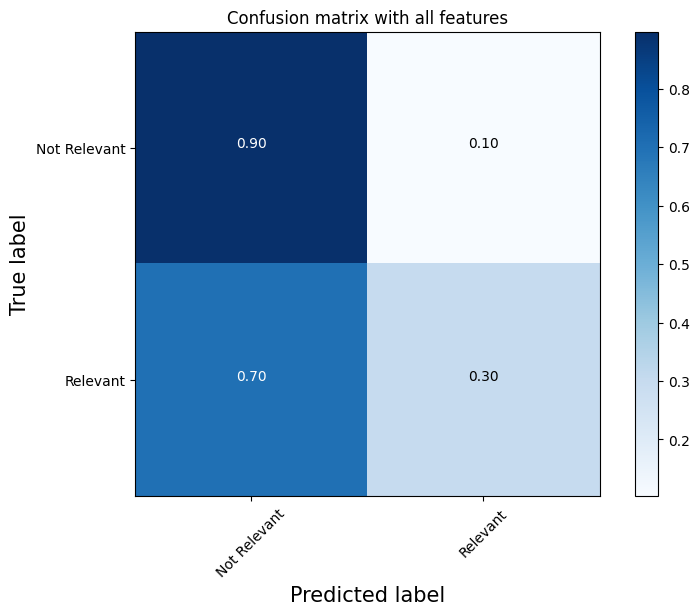

In [158]:
# Step 4: Evaluate the classifier using various measures

import itertools
from sklearn.metrics import roc_auc_score

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize=15)
    plt.xlabel('Predicted label',fontsize=15)


# Print accuracy:
print("Accuracy: ", accuracy_score(y_test, y_pred_class))


# print the confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['Not Relevant','Relevant'],normalize=True,
                      title='Confusion matrix with all features')

# calculate AUC: Area under the curve(AUC) gives idea about the model efficiency:
# Further information: https://en.wikipedia.org/wiki/Receiver_operating_characteristic
y_pred_prob = nb.predict_proba(X_test_dtm)[:, 1]
print("ROC_AOC_Score: ", roc_auc_score(y_test, y_pred_prob))

CPU times: user 6.14 ms, sys: 4 µs, total: 6.15 ms
Wall time: 6.16 ms
Accuracy:  0.6886886886886887


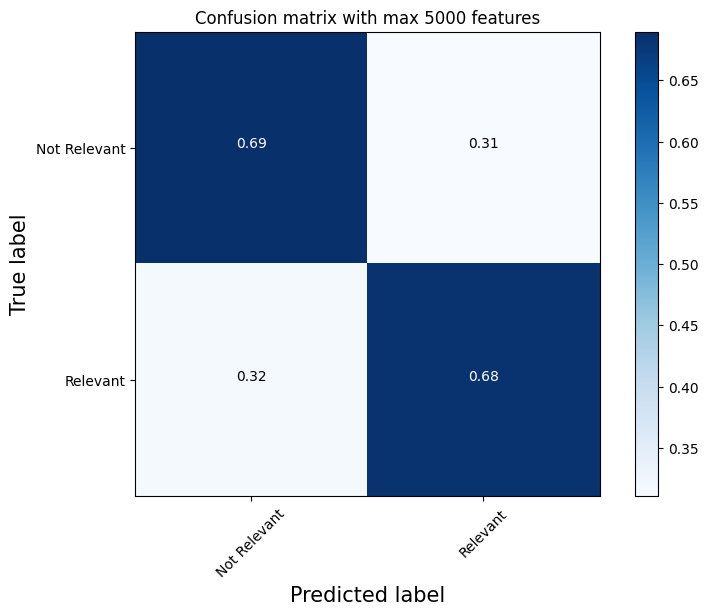

In [159]:
vect = CountVectorizer(max_features=5000) # Step-1
X_train_dtm = vect.fit_transform(X_train) # combined step 2 and 3
X_test_dtm = vect.transform(X_test)
nb = MultinomialNB() # instantiate a Multinomial Naive Bayes model
%time nb.fit(X_train_dtm, y_train) # train the model(timing it with an IPython "magic command")
y_pred_class = nb.predict(X_test_dtm) # make class predictions for X_test_dtm
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred_class))
# print the confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['Not Relevant','Relevant'],normalize=True,
                      title='Confusion matrix with max 5000 features')

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.7202202202202203
AUC:  0.7243233889877674


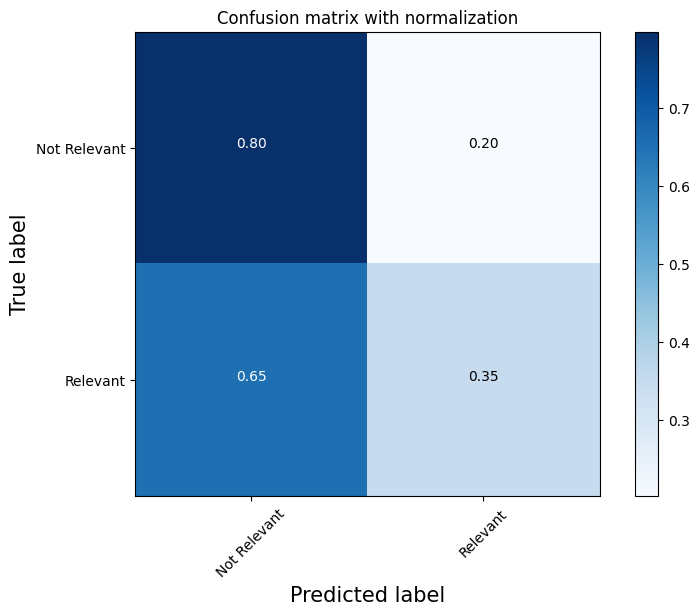

In [160]:
# trying LogisticRegression
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(class_weight='balanced')
logreg.fit(X_train_dtm , y_train)

# make prediction on test data
y_pred_class = logreg.predict(X_test_dtm)

# calculate evaluation measures:
print("Accuracy:" , accuracy_score(y_test , y_pred_class))
print("AUC: ", roc_auc_score(y_test , y_pred_prob))
cnf_matrix = confusion_matrix(y_test , y_pred_class)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['Not Relevant','Relevant'],normalize=True,
                      title='Confusion matrix with normalization')

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy:  0.6821821821821822
AUC:  0.7243233889877674


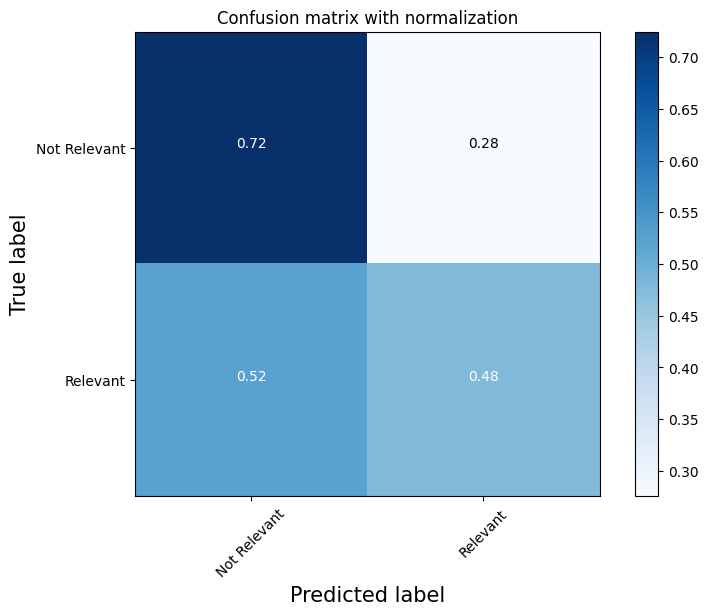

In [162]:
from sklearn.svm import LinearSVC

vect = CountVectorizer(max_features=1000) # Step-1
X_train_dtm = vect.fit_transform(X_train) # combined step 2 and 3
X_test_dtm = vect.transform(X_test)

classifier = LinearSVC(class_weight='balanced') # instantiate a logistic regression model
classifier.fit(X_train_dtm, y_train) # fit the model with training data

# Make predictions on test data
y_pred_class = classifier.predict(X_test_dtm)

# calculate evaluation measures:
print("Accuracy: ", accuracy_score(y_test, y_pred_class))
print("AUC: ", roc_auc_score(y_test, y_pred_prob))
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['Not Relevant','Relevant'],normalize=True,
                      title='Confusion matrix with normalization')

if we see purely based on accuracy alonse first classifier is good. however most probably based on my intuition that due to imbalanced dataset our model is doing fine with classifying non relevant but failed when predicting the relevant since only small number of population in our dataset is relevant